# AAI Course: TSNE Visualization (Part IV)

## Word2Vec & t-SNE

#### Data Source: 
**The preprocessing step has produced final.sqlite file after doing the data preparation & clearning.** The review text is now devoid of punctuations, HTML markups and stop words.

#### Objective:
**To plot t-SNE plot after doing Word2Vec.** The aim is to check whether there is a separation between data points.<br><br>

## Preprocessed Data Loading

In [48]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            import sqlite3
import pdb
import re
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./final.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

print(final.head(3))
#pdb.set_trace()

    index      Id   ProductId          UserId            ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
2  138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   
2                     1                       1  positive  1191456000   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   
2               chicken soup with rice months   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   
2  This is a fun way for children to learn their ... 

## Word2Vec & Average W2V

We need to train our own Word2Vec model using our own text corpus. Word2Vec outputs **a dense matrix with limited number of features**. Thus, there is no need to use any other dimensionality reduction method like PCA or TruncatedSVD.

Average W2V is done to take the average w2v vector of all the words containing the review.

In [49]:
# Train your own Word2Vec model using your own text corpus
import gensim
import re

#function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


#select subset of points for fast execution
num_points = 50000
i=0
list_of_sent=[]

for sent in final['CleanedText'].head(num_points).values.astype('str'):
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    
    
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 

In [65]:
# average Word2Vec
# compute average word2vec for each review.

# the avg-w2v for each sentence/review is stored in this list
sent_vectors = []; 
for sent in final['CleanedText'].head(
        num_points).values.astype('str'): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
print(len(sent_vectors))
print(len(sent_vectors[0]))


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


1000
50


# t-SNE Visualisation

The output of Average W2V is fed into t-SNE for visualization.

In [66]:
# TSNE: perp = 60

from sklearn.manifold import TSNE
from sklearn import preprocessing

#from MulticoreTSNE import MulticoreTSNE as TSNE

#tsne = TSNE(n_jobs=1)#, n_components=2, 
#    random_state=0, perplexity = 100, n_iter = 1000)
#tsne_data = tsne.fit_transform(data_1000)

# standardized_sent_vec = preprocessing.scale(
#    np.nan_to_num(sent_vectors[1:num_points]))

model = TSNE(n_components=2, verbose=2, 
             random_state=0, perplexity = 60, n_iter = 1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(np.nan_to_num(sent_vectors[1:num_points]))


[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 999 samples in 0.000s...
[t-SNE] Computed neighbors for 999 samples in 0.220s...
[t-SNE] Computed conditional probabilities for sample 999 / 999
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.510s
[t-SNE] Iteration 50: error = 77.5486526, gradient norm = 0.4064248 (50 iterations in 4.561s)
[t-SNE] Iteration 100: error = 77.4350510, gradient norm = 0.3963271 (50 iterations in 4.410s)
[t-SNE] Iteration 150: error = 77.9087906, gradient norm = 0.4016456 (50 iterations in 4.330s)
[t-SNE] Iteration 200: error = 78.3412933, gradient norm = 0.4290701 (50 iterations in 4.350s)
[t-SNE] Iteration 250: error = 79.5749588, gradient norm = 0.4045194 (50 iterations in 4.381s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.574959
[t-SNE] Iteration 300: error = 1.1543367, gradient norm = 0.0038270 (50 iterations in 4.602s)
[t-SNE] Iteration 350: error = 0.9539952, gradient norm = 0.0002615 

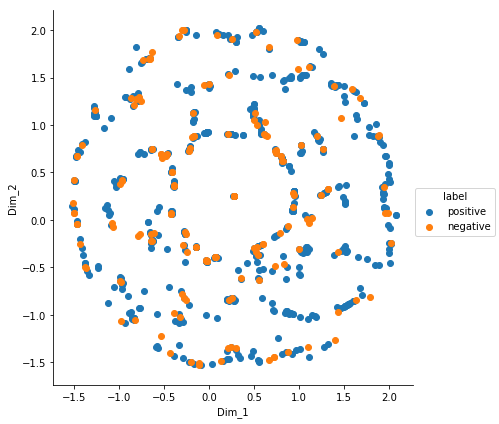

In [67]:
#To plot the t-sne data

labels_1000 = final['Score'].head(num_points-1)

# creating a new data frame which help us in ploting the result data
tsne_data_wlabel = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data_wlabel, 
                       columns=["Dim_1", "Dim_2", "label"])

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(
    plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

## t-SNE Plot: Second Run with different Perp Value

[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 999 samples in 0.010s...
[t-SNE] Computed neighbors for 999 samples in 0.230s...
[t-SNE] Computed conditional probabilities for sample 999 / 999
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.650s
[t-SNE] Iteration 50: error = 66.7849808, gradient norm = 0.4418731 (50 iterations in 5.251s)
[t-SNE] Iteration 100: error = 69.2846909, gradient norm = 0.4298845 (50 iterations in 5.383s)
[t-SNE] Iteration 150: error = 68.5817337, gradient norm = 0.4281791 (50 iterations in 5.114s)
[t-SNE] Iteration 200: error = 67.1570053, gradient norm = 0.4373719 (50 iterations in 5.223s)
[t-SNE] Iteration 250: error = 68.0285416, gradient norm = 0.4193419 (50 iterations in 5.291s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.028542
[t-SNE] Iteration 300: error = 0.5755547, gradient norm = 0.0016443 (50 iterations in 4.673s)
[t-SNE] Iteration 350: error = 0.4025976, gradient norm = 0.0002622 

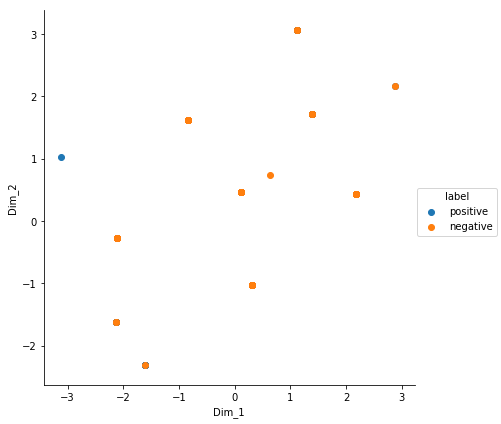

In [69]:

#To run t-sne with diff perp value = 75

model = TSNE(n_components=2, verbose=2, 
             random_state=0, perplexity = 75, n_iter = 1000)

tsne_data = model.fit_transform(
    np.nan_to_num(sent_vectors[1:num_points]))

# creating a new data frame which help us in ploting the result data
tsne_data_wlabel = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(
    data=tsne_data_wlabel, columns=["Dim_1", "Dim_2", "label"])

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(
    plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Observations

1. t-SNE is done with different perplexity and step values. **We can find some structure of the data, but separation is stll a distant dream.**
2. The data points are circularly distributed & overlapping when perplexity < 70 and when perplexity > 70, then many positive points are clubbed as one single point.
3. We will experiment with TF-IDF weighted W2V as it is known to perform better.